# Load file

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import plotly.graph_objects as go
from scipy import linalg
import seaborn as sns

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

In [ ]:
G_java = nx.drawing.nx_pydot.read_dot('/content/Java_graph_new.dot')
G_r = nx.drawing.nx_pydot.read_dot('/content/R_graph.dot')
G_python = nx.drawing.nx_pydot.read_dot('/content/python_graph.dot')
network = {'Java': G_java, 'R': G_r, 'Python': G_python}

# Dynamic importance

In [ ]:
##  Calculate dynamic importance for all nodes in the network with optimizations
def calculate_dynamic_importance(G):
    # Convert directed graph to undirected and get largest connected component
    G_undirected = G.to_undirected()
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_connected = G_undirected.subgraph(largest_cc)

    # Get sparse adjacency matrix and convert to float type
    A_sparse = nx.adjacency_matrix(G_connected, weight=None).astype(float)

    try:
        # Calculate principal eigenvector using power method for better stability
        eigenvals, right_eigenvecs = eigs(A_sparse, k=1, which='LR', maxiter=1000)
        _, left_eigenvecs = eigs(A_sparse.T, k=1, which='LR', maxiter=1000)

        # Get the principal eigenvectors
        v = left_eigenvecs[:, 0].real
        u = right_eigenvecs[:, 0].real

        # Normalize eigenvectors for numerical stability
        v = v / np.linalg.norm(v)
        u = u / np.linalg.norm(u)

        denominator = np.dot(v.T, u)

        # Vectorized importance calculation
        importance = {}
        node_list = list(G_connected.nodes())
        imp_values = np.abs((v * u) / denominator)
        max_importance = np.max(imp_values)

        importance = dict(zip(node_list, imp_values))

        # Add zero importance for nodes not in largest component
        for node in G.nodes():
            if node not in importance:
                importance[node] = 0.0

        return importance, max_importance

    except Exception as e:
        print(f"Error in eigenvalue calculation: {e}")
        return None, None

In [ ]:
##  Create network visualization with node sizes based on importance values
def visualize_network_importance(G, importance, title):
    plt.figure(figsize=(12, 8))

    # Create layout
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)

    # Draw nodes
    node_sizes = [importance[node] * 5000 for node in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=list(importance.values()),
                                 cmap='viridis',
                                 alpha=0.7)

    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add colorbar
    plt.colorbar(nodes, label='Dynamic Importance')

    plt.title(f"{title} Network - Node Dynamic Importance")
    plt.axis('off')
    plt.tight_layout()


In [ ]:
## Create histogram of importance values
def plot_importance_distribution(importance_dict, title):
    plt.figure(figsize=(10, 6))
    values = list(importance_dict.values())

    sns.histplot(values, bins=30, kde=True)
    plt.axvline(max(values), color='r', linestyle='--',
                label=f'Max Importance: {max(values):.4f}')

    plt.title(f"{title} Network - Dynamic Importance Distribution")
    plt.xlabel("Dynamic Importance")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()


Processing Java network...
Java Maximum Dynamic Importance: 0.1764

Top 5 most important nodes:
java.lang.String: 0.1764
java.lang.Object: 0.1222
java.lang.IllegalArgumentException: 0.0395
java.lang.Class: 0.0191
java.io.ObjectInputStream: 0.0158

Processing R network...
R Maximum Dynamic Importance: 0.4109

Top 5 most important nodes:
R: 0.4109
methods: 0.0241
stats: 0.0223
MASS: 0.0122
utils: 0.0075

Processing Python network...
Python Maximum Dynamic Importance: 0.1257

Top 5 most important nodes:
requests: 0.1257
six: 0.0476
sphinx: 0.0383
coverage: 0.0379
mock: 0.0335


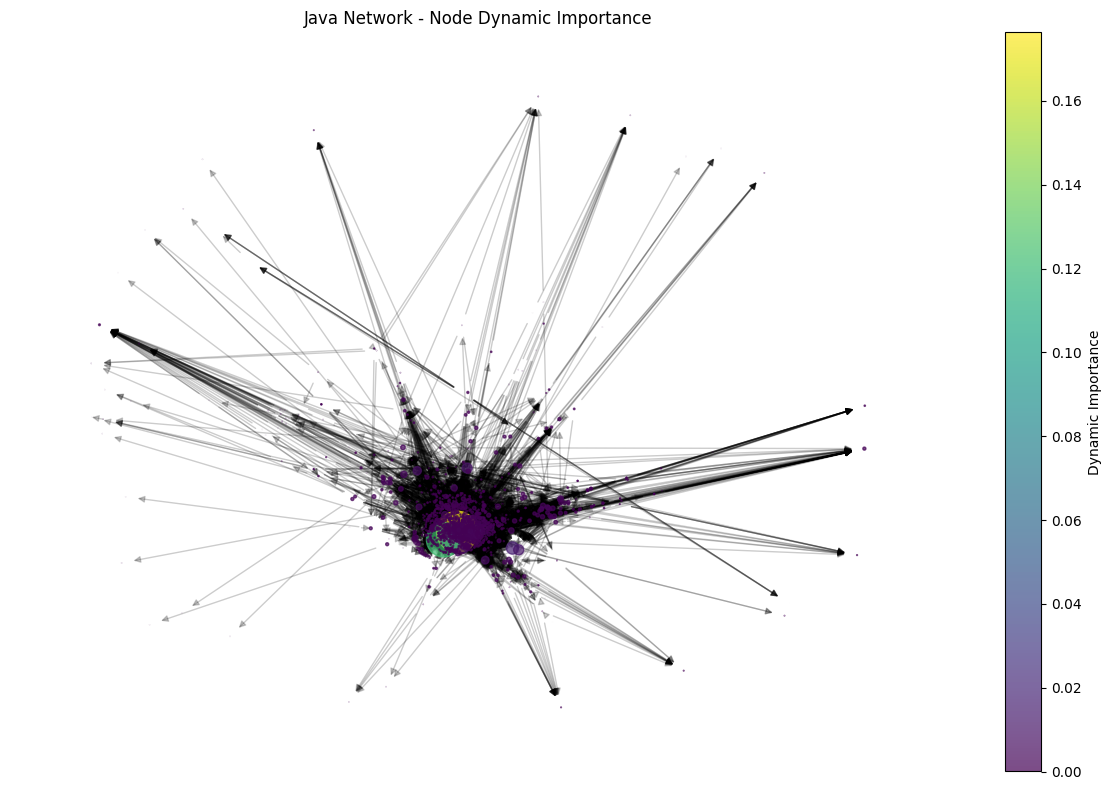

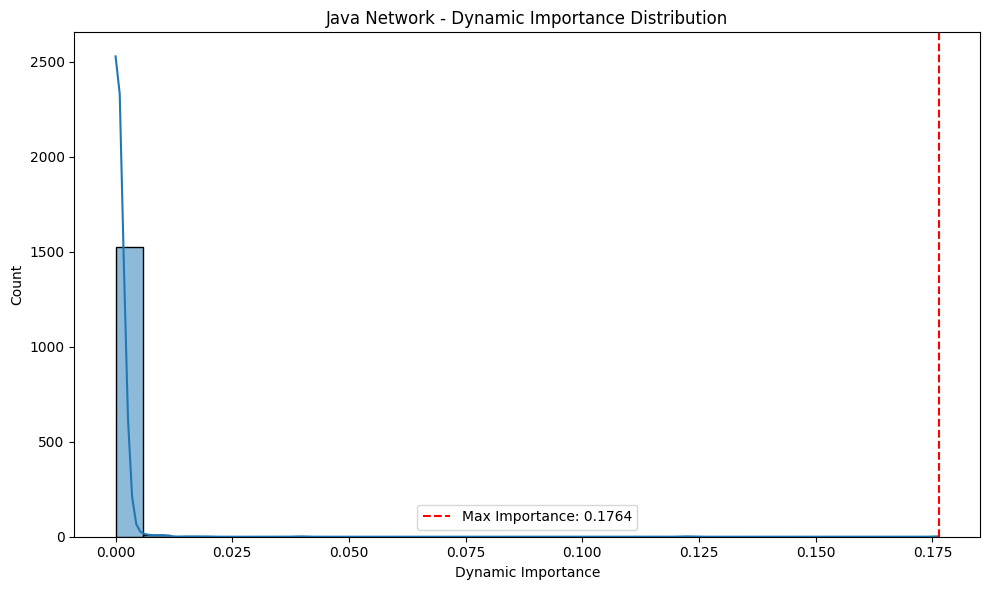

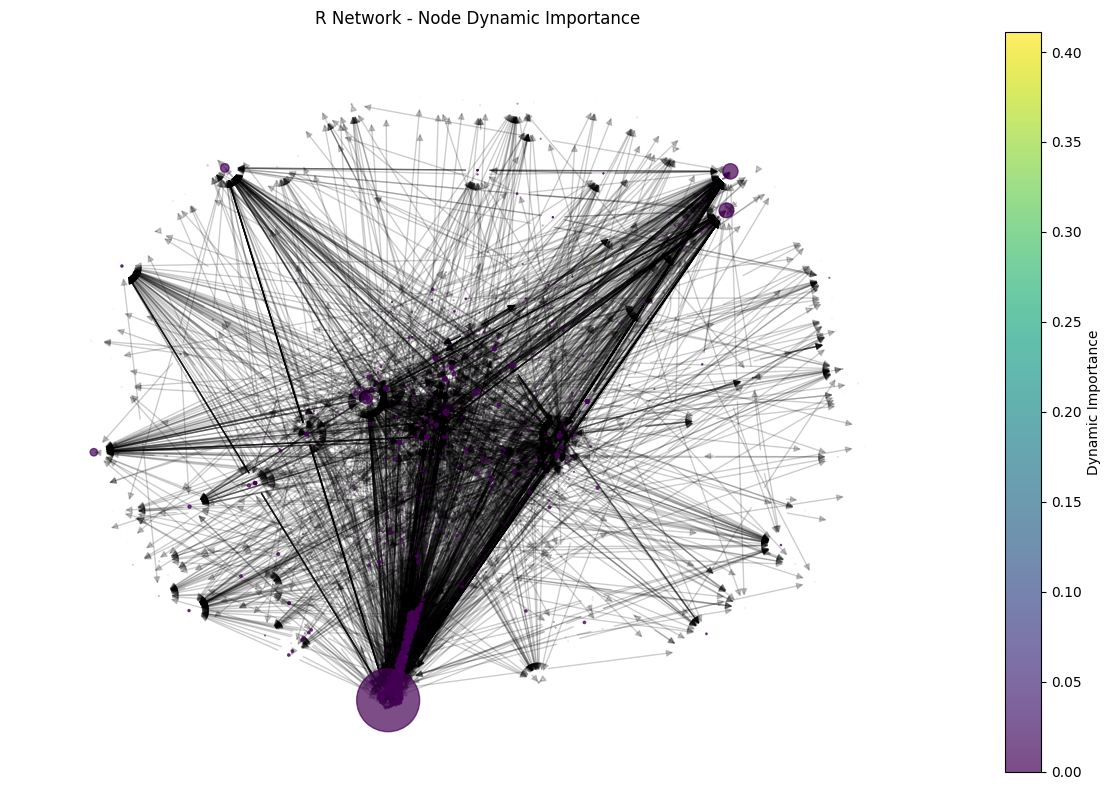

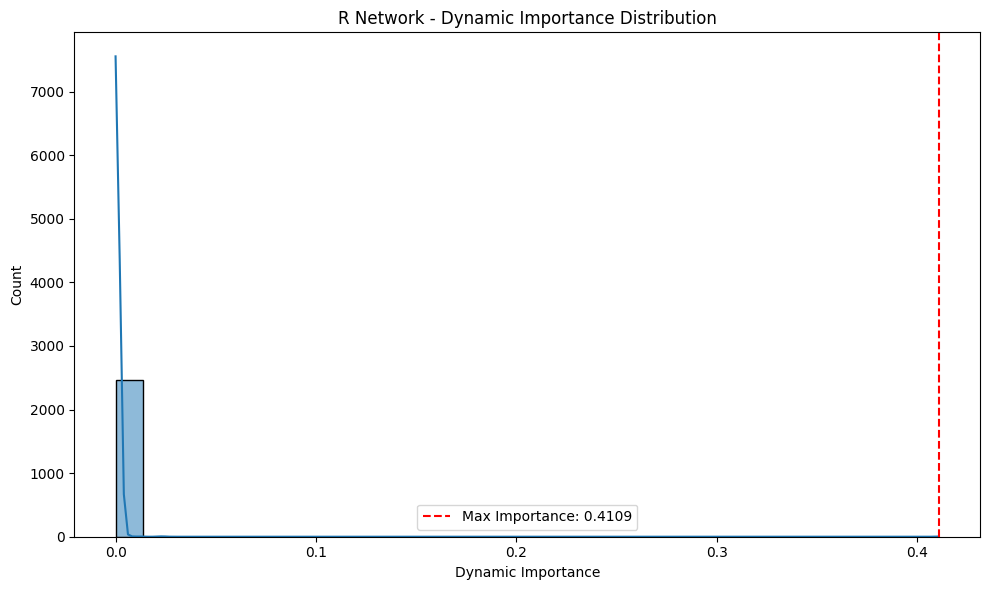

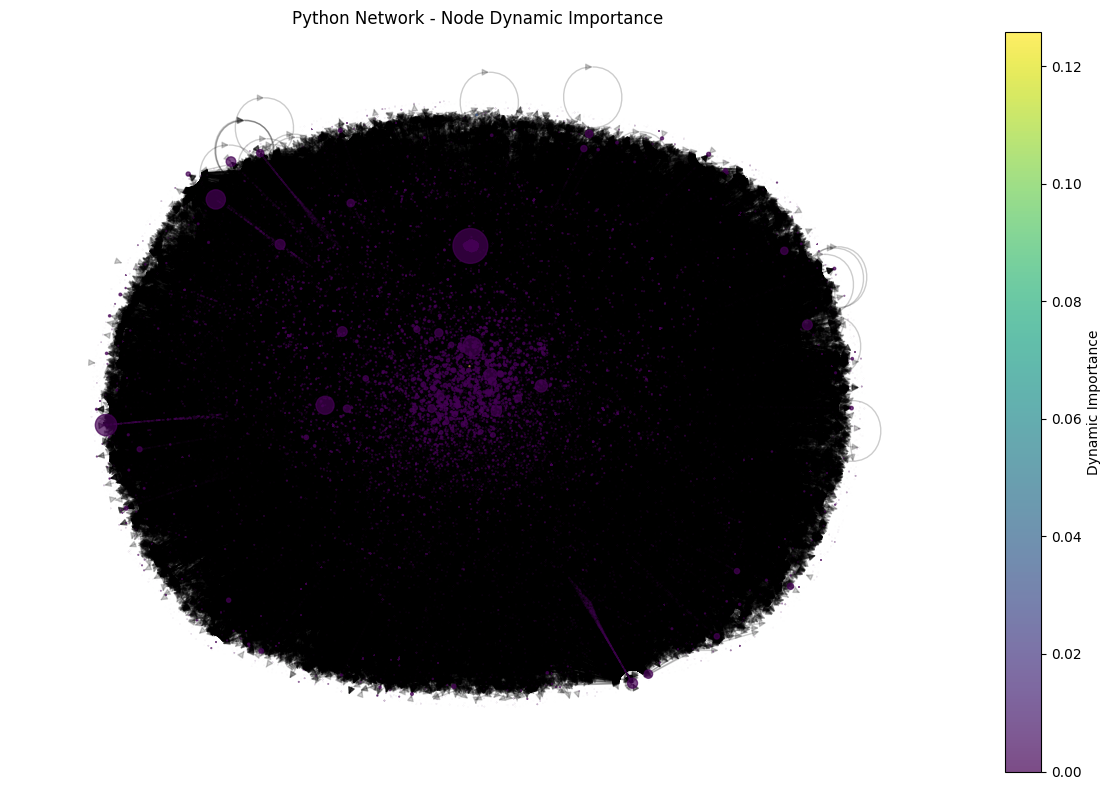

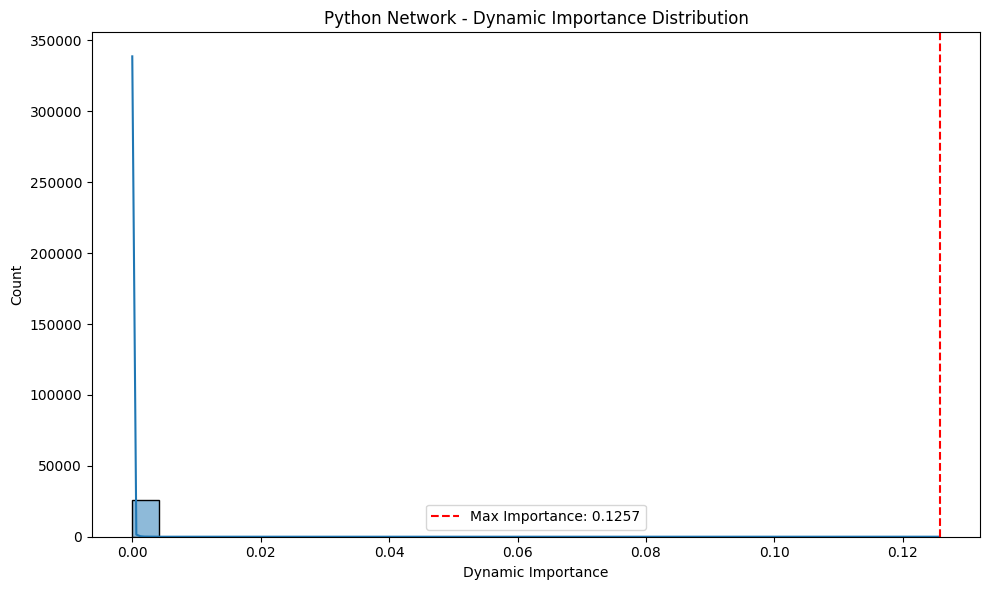

In [ ]:
# Calculate and visualize for each network
for lang, G in network.items():
    print(f"\nProcessing {lang} network...")

    # Calculate importance
    importance, max_imp = calculate_dynamic_importance(G)

    if importance is not None:
        print(f"{lang} Maximum Dynamic Importance: {max_imp:.4f}")

        # Find most important nodes
        top_nodes = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nTop 5 most important nodes:")
        for node, imp in top_nodes:
            print(f"{node}: {imp:.4f}")

        # Create visualizations
        visualize_network_importance(G, importance, lang)
        plot_importance_distribution(importance, lang)
    else:
        print(f"Failed to calculate importance for {lang} network")

plt.show()